<a href="https://colab.research.google.com/github/Karima04/Brustkrebs-mit-Deep-Learning/blob/main/BCancer_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import**

In [ ]:
# utility modules
import tqdm
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import DataLoader


# modules for CNN
import torch
import torch.optim as optim
import torchvision
from torch import nn
from torch import Tensor
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F


# modules for visualization
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
import plotly.graph_objects as go
from google.colab.patches import cv2_imshow
from PIL import Image

# hyperparameters optimization
try:
  import optuna
except:
  os.system("pip install "+ "optuna"+" --quiet")
  import optuna

# Modules for metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Features Importance
try:
  import shap
except:
  os.system("pip install "+ "shap"+" --quiet")
  import shap

#**Pytorch device**

In [ ]:
print(torch.__version__)

def get_torch_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

1.11.0+cu113


#**import data and process It**

In [ ]:
# Download Data set MIAS
from google.colab import drive
drive.mount('/content/drive/', force_remount=False)

#Create Folder
#!mkdir /content/drive/MyDrive/Breast_cancer_pytorch
#!ls /content/drive/MyDrive

def Download_Mias_Dataset():
  
  # Define the remote file to retrieve
  remote_url = 'http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz'
  # Define the local filename to save data
  local_file = '/content/drive/MyDrive/Breast_cancer_pytorch/all-mias.tar.gz'
  # Make http request for remote file data
  downloaded_path = wget.download(remote_url, local_file)
  return downloaded_path

# Extract tar.gz file

def Extract_Mias_Files(file_path):
  import tarfile
  
  # open file
  file = tarfile.open(file_path)
    
  # extract files
  file.extractall('/content/drive/MyDrive/Breast_cancer_pytorch/dataset')
    
  # close file
  file.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#**Data Augmentation**

In [ ]:
################## RUN THIS ONLY THE FIRST TIME ################################
# Download Mias
# Direct Link http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz
# path_to_mias = Download_Mias_Dataset()
# Extract_Mias_Files(path_to_mias)
################################################################################

%%time
url = '/content/drive/MyDrive/Breast_cancer_pytorch/dataset/'

# Rotation of images
no_angles = list(range(0,360,1)) 
print('Rotated images with:',no_angles)

# read each image in dataset
def read_image():
    transform = transforms.Compose([transforms.ToTensor()])
    info = {}
    for i in tqdm.trange(322):
        if i<9:
            image_name='mdb00'+str(i+1)
        elif i<99:
            image_name='mdb0'+str(i+1)
        else:
            image_name = 'mdb' + str(i+1)
        image_address= url+image_name+'.pgm'
        img = cv2.imread(image_address, 0) # Gray scale
        img = cv2.resize(img, (64,64))   #resize image: 1024 × 1024 to 64 x 64
        rows, cols = img.shape
        #print(rows,cols) 
        info[image_name]={}
        for angle in no_angles: # Rotation ) 
            # get the center coordinates of the
            # image to create the 2D rotation
            # matrix
            center = (cols / 2, rows / 2)
            ## to get the rotation matrix
            rotate_m = cv2.getRotationMatrix2D(center, angle, 1)    # Rotate: Begin with 0 degree
            ## rotate the image using cv2.warpAffine
            img_rotated = cv2.warpAffine(img, rotate_m, (cols, rows))
            # img_rotated=np.vstack(img_rotated).astype(np.float32)
            # img_rotated = torch.from_numpy(img_rotated)
            info[image_name][angle]=img_rotated    # result => {angle:image array}
    return (info)

#label of generated/rotated B and M images
def read_label():
    filename = url+'image_infos.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    del lines[0]
    info={}
    for line in lines:
      words=line.split(' ')
      if len(words)>3:
          # print(words)
          if (words[3] == 'B'):
              info[words[0]] = {}
              for angle in no_angles: 
                info[words[0]][angle] = 0
          if (words[3] == 'M'):
            info[words[0]] = {}
            for  angle in no_angles: 
              info[words[0]][angle] = 1
    # print(info)           
    return (info)

print(50*'*')
print('Total of Images with Tumors:',len(read_label()))
print('Total of rotated Images with Tumors:',len(read_label())*(360))
print(50*'*')

Rotated images with: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217

100%|██████████| 322/322 [01:42<00:00,  3.13it/s]


mdb249-Bild mit hoher Brustdichte und Verkalkung (X=575, Y=639): Tumor mit einem Radius von 64 als bösartig diagnostiziert



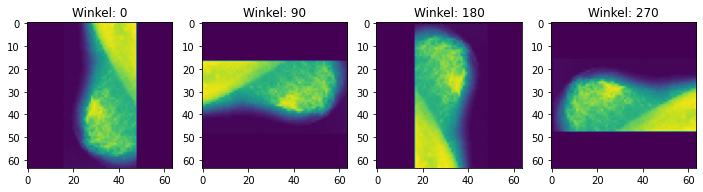

In [ ]:
####### Plotting #########
# e.g. 4 angles of image 'mdb249' rotation
info_label = read_label()
info_image = read_image()
indx= [0,1,2,3] 
f, axs = plt.subplots(1,4,figsize=(12,3))
print ('mdb249-Bild mit hoher Brustdichte und Verkalkung (X=575, Y=639): Tumor mit einem Radius von 64 als\033[1m bösartig\033[0m diagnostiziert\n')
for i in indx:
  axs[i].imshow(info_image['mdb249'][i*90])
  axs[i].title.set_text('Winkel: '+ str(i*90))
plt.show()

mdb223-Bild mit hoher Brustdichte und Verkalkung (X=523, Y=482): Tumor mit einem Radius von 29 als gutartig diagnostiziert



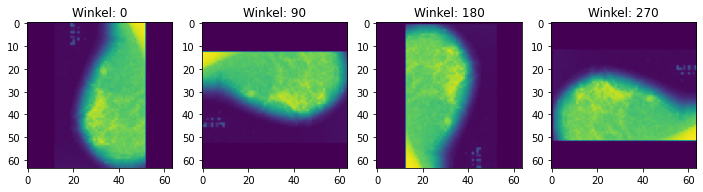

In [ ]:
#e.g. 4 angles of image 'mdb023' rotation
print ('mdb223-Bild mit hoher Brustdichte und Verkalkung (X=523, Y=482): Tumor mit einem Radius von 29 als \033[1mgutartig\033[0m diagnostiziert\n')
f, axs = plt.subplots(1,4,figsize=(12,3))
for i in indx:
  axs[i].imshow(info_image['mdb023'][i*90])
  axs[i].title.set_text('Winkel: '+ str(i*90))
plt.show()

# **CNN & Optuna**

In [ ]:
# updated model
class ConvNet(nn.Module):
    def __init__(self, trial):
        # We optimize dropout rate in CNN
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        dropout_rate = trial.suggest_float("dropout_rate", 0, 0.9,step=0.1)
        self.drop1=nn.Dropout(p=dropout_rate)   
        fc2_input_dim = trial.suggest_int("fc2_input_dim", 32, 2048,32)  #suggest_int(name, low, high[, step, log])  
        self.fc1 = nn.Linear(128*32*32, fc2_input_dim)
        self.fc1_bn = nn.BatchNorm1d(fc2_input_dim)
        dropout_rate2 = trial.suggest_float("dropout_rate2", 0, 0.9,step=0.1)
        self.drop2=nn.Dropout(p=dropout_rate2)
        self.fc2 = nn.Linear(fc2_input_dim, 2)

    def forward(self, x):  # Conv - BatchNorm - Activ - Pool - Drop
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        x = self.conv4(x)        
        x = F.relu(F.max_pool2d(self.conv4_bn(x),kernel_size = 2,stride=2))
        x = self.drop1(x)
        x = x.view(x.size(0),-1)  # Flatten
        x = self.fc1(x)
        x = F.relu(self.fc1_bn(x))
        x = self.drop2(x)
        x = self.fc2(x)
        return x

# **Split Data**

In [ ]:
%%time
def pre_training():
    label_info = read_label()
    image_info = read_image()
    ids=label_info.keys()   
    X = []
    Y = []
    for id in ids:
        for angle in no_angles:
            X.append(image_info[id][angle])
            Y.append(label_info[id][angle])
    X=np.array(X)
    Y=np.array(Y)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
    train_dt = TensorDataset(torch.from_numpy(x_train).unsqueeze(1), torch.from_numpy(y_train)) #(1,28,28)
    test_dt = TensorDataset(torch.from_numpy(x_test).unsqueeze(1), torch.from_numpy(y_test))
    print("Number of training images: "+str(len(train_dt)))
    print("Number of testing images: "+str(len(test_dt)))
    return [train_dt, test_dt]
# pre_training()  
print(50*'*') 
x_train_d, x_test_d = pre_training() # return TensorDataset 
print(50*'*')

**************************************************


100%|██████████| 322/322 [00:58<00:00,  5.51it/s]


Number of training images: 28980
Number of testing images: 12420
**************************************************
CPU times: user 6 s, sys: 1.96 s, total: 7.96 s
Wall time: 58.8 s


# **Train and Evaluate model**



In [ ]:
###################### MAIN ###########################
# Objective Function
# to maximize: Accuracy, Precision, Recall and F1-Score
#######################################################

EPOCHS = 10
train_accuracy = {}
eval_accuracy = {}
train_loss = {}
eval_loss = {}
cf_matrix = {}
classes = ('M-bösartig', 'B-gutartig')
roc = {}
roc_auc = {}

def objective(trial):

    # Generate the model
    model = ConvNet(trial)
    model.type(torch.cuda.FloatTensor).to(device)

    # Generate the optimizers: Adam, AdaDelta and Adagrad
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "Adadelta","Adagrad"])
    # Generate learning rate 
    lr = trial.suggest_float("lr", 1e-5, 1e-1,log=True) 
    # Randomize lr and optimizer
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr) 
    # Generate batchsize
    batch_size=trial.suggest_int("batch_size", 32, 256,step=32) 
    # Loss calculation function
    criterion=nn.CrossEntropyLoss()

    # Get the MIAS imagesset.
    train_loader = DataLoader(x_train_d, batch_size, shuffle=True)  
    valid_loader = DataLoader(x_test_d, batch_size, shuffle=True)
    
    # Training of the model.
    train_accuracy["train_accuracy"+str(trial.number)] = []
    train_loss["train_loss"+str(trial.number)] = []
    eval_accuracy["eval_accuracy"+str(trial.number)] = []
    eval_loss["eval_loss"+str(trial.number)] = []
    roc["trial_"+str(trial.number)] = {}

    for epoch in tqdm.trange(EPOCHS):  
        # switch to train mode
        model.train()
        acc_train = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            # copy inputs to device
            images = images.type(torch.cuda.FloatTensor).to(device)
            labels = labels.to(device)
            # zero the gradient
            optimizer.zero_grad()
            # compute the output and loss
            output = model(images)
            loss = criterion(output, labels).to(device)
            pred = output.argmax(dim=1, keepdim=True)
            acc_train = accuracy_score(labels.view(-1).cpu(), pred.cpu())
            # backpropagation
            loss.backward()
            # apply gradient and update the weights
            optimizer.step()

        # to plot train loss and train accuracy
        train_loss["train_loss"+str(trial.number)].append(loss.item())
        train_accuracy["train_accuracy"+str(trial.number)].append(acc_train)

        # model validation
        # switch to eval mode
        model.eval()
        
        pred_list = torch.zeros(0,dtype=torch.long, device='cpu')
        label_list = torch.zeros(0,dtype=torch.long, device='cpu')
        model_loss = 0
        model_accuracy = 0
        model_precision = 0
        model_recall = 0
        model_f1 = 0
        # disable gradient during validation
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(valid_loader):
              images = images.type(torch.cuda.FloatTensor).to(device)
              labels = labels.to(device)
              output = model(images)
              # calculate the labels batch loss
              loss = criterion(output, labels).to(device)
              model_loss = loss.item()
              # Get the index of the max log-probability.
              pred = output.argmax(dim=1, keepdim=True)
              # classifiction metrics
              model_accuracy = accuracy_score(labels.view(-1).cpu(), pred.cpu())
              model_precision = precision_score(labels.view(-1).cpu(), pred.cpu(), zero_division=0)  # zero_division??
              model_recall = recall_score(labels.view(-1).cpu(), pred.cpu(), zero_division=0)
              model_f1 = f1_score(labels.view(-1).cpu(), pred.cpu(), zero_division=0)
              
              ### Start storing Predicted labels ### 
              pred_list = torch.cat([pred_list,pred.view(-1).cpu()])
              ### End storing predicted labels ###
              
              ### Start storing true labels ###
              label_list = torch.cat([label_list,labels.view(-1).cpu()])
              ### End storing true labels ###
              
        # To plot test loss & test accuracy 
        eval_loss["eval_loss"+str(trial.number)].append(model_loss)
        eval_accuracy["eval_accuracy"+str(trial.number)].append(model_accuracy)

    # confusion matrix
    cf_matrix["trial_"+str(trial.number)] = confusion_matrix(label_list, pred_list) # normalize='all'

    fpr, tpr, threshold = roc_curve(label_list, pred_list)
    roc["trial_"+str(trial.number)]['fpr'] = fpr
    roc["trial_"+str(trial.number)]['tpr'] = tpr
    roc["trial_"+str(trial.number)]['threshold'] = threshold
    roc_auc["trial_"+str(trial.number)] = auc(fpr, tpr)
  
    return model_accuracy, model_precision, model_recall, model_f1 # accuracy, precision, recall, f1 score
       

In [ ]:
# Output of objective function
################################################################################################
#  to "maximize" :
# Accuracy= TP+TN/TP + FP + FN + TN
# Precision = TP/TP+FP
# Recall = TP/TP+FN
# F1 Score = 2*(Recall * Precision) / (Recall + Precision)
#################################################################################################
# Sampler = none by multi objective ---> NSGAIISampler (Nondominated Sorting Genetic Algorithm II)
study = optuna.create_study(directions=['maximize', 'maximize', 'maximize', 'maximize']) 
study.optimize(objective, n_trials=5)
#################################################################################################
best_trials = study.best_trials
print('Best trial number is : {}'.format(best_trials[0].number))
print('The Accuracy is: {}, Precision score is : {}, Recall score is :  {} and f1 score is : {}'.format(best_trials[0].values[0], best_trials[0].values[1], best_trials[0].values[2], best_trials[0].values[3])) 
print("Best hyperparameters: {}".format(best_trials[0].params))

[I 2022-05-17 19:26:02,872] A new study created in memory with name: no-name-93a772a0-ade5-4b47-91fb-c84037132703
100%|██████████| 10/10 [08:57<00:00, 53.74s/it]
[I 2022-05-17 19:35:01,734] Trial 0 finished with values: [1.0, 1.0, 1.0, 1.0] and parameters: {'dropout_rate': 0.7000000000000001, 'fc2_input_dim': 1024, 'dropout_rate2': 0.1, 'optimizer': 'Adadelta', 'lr': 0.00580851912609547, 'batch_size': 256}. 
100%|██████████| 10/10 [08:33<00:00, 51.38s/it]
[I 2022-05-17 19:43:35,990] Trial 1 finished with values: [1.0, 1.0, 1.0, 1.0] and parameters: {'dropout_rate': 0.2, 'fc2_input_dim': 416, 'dropout_rate2': 0.6000000000000001, 'optimizer': 'Adagrad', 'lr': 0.0001395247129494778, 'batch_size': 160}. 
100%|██████████| 10/10 [10:28<00:00, 62.89s/it]
[I 2022-05-17 19:54:06,538] Trial 2 finished with values: [1.0, 1.0, 1.0, 1.0] and parameters: {'dropout_rate': 0.0, 'fc2_input_dim': 1376, 'dropout_rate2': 0.7000000000000001, 'optimizer': 'Adagrad', 'lr': 0.0015052921420418762, 'batch_size'

Best trial number is : 0
The Accuracy is: 1.0, Precision score is : 1.0, Recall score is :  1.0 and f1 score is : 1.0
Best hyperparameters: {'dropout_rate': 0.7000000000000001, 'fc2_input_dim': 1024, 'dropout_rate2': 0.1, 'optimizer': 'Adadelta', 'lr': 0.00580851912609547, 'batch_size': 256}


In [ ]:
# #save Trails
# import joblib
# study = optuna.create_study()
# joblib.dump(study, "/content/drive/MyDrive/Breast_cancer_pytorch/study.pkl")

[I 2022-05-17 19:01:47,973] A new study created in memory with name: no-name-02c7d0bb-7284-4f12-bc9e-f5942efddac2


['/content/drive/MyDrive/Breast_cancer_pytorch/study.pkl']

In [ ]:
# trails as Dataframe
df_trails = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
df_trails.rename({'values_0': 'Accuracy', 'values_1':'Precision', 'values_2': 'Recall', 'values_3': 'F1-Score' }, axis=1, inplace=True)
df_trails

,Accuracy,Precision,Recall,F1-Score,params_batch_size,params_dropout_rate,params_dropout_rate2,params_fc2_input_dim,params_lr,params_optimizer,system_attrs_nsga2:generation
0,1.000000,1.000000,1.000000,1.000000,256,0.7,0.1,1024,0.005809,Adadelta,0
1,1.000000,1.000000,1.000000,1.000000,160,0.2,0.6,416,0.000140,Adagrad,0
2,1.000000,1.000000,1.000000,1.000000,96,0.0,0.7,1376,0.001505,Adagrad,0
3,1.000000,1.000000,1.000000,1.000000,96,0.2,0.3,1056,0.000040,Adagrad,0
4,0.984848,0.985507,0.985507,0.985507,192,0.3,0.0,960,0.000704,Adadelta,0


## **Best Trials**

In [ ]:
# The best trials
print("number of best trials : {}".format(len(study.best_trials)))
print('Accuracy, Precision, Recall, F1-Score')
for i in range(len(study.best_trials)):
  print(study.best_trials[i])

number of best trials : 4
Accuracy, Precision, Recall, F1-Score
FrozenTrial(number=0, values=[1.0, 1.0, 1.0, 1.0], datetime_start=datetime.datetime(2022, 5, 17, 19, 26, 2, 878541), datetime_complete=datetime.datetime(2022, 5, 17, 19, 35, 1, 734150), params={'dropout_rate': 0.7000000000000001, 'fc2_input_dim': 1024, 'dropout_rate2': 0.1, 'optimizer': 'Adadelta', 'lr': 0.00580851912609547, 'batch_size': 256}, distributions={'dropout_rate': DiscreteUniformDistribution(high=0.9, low=0.0, q=0.1), 'fc2_input_dim': IntUniformDistribution(high=2048, low=32, step=32), 'dropout_rate2': DiscreteUniformDistribution(high=0.9, low=0.0, q=0.1), 'optimizer': CategoricalDistribution(choices=('Adam', 'Adadelta', 'Adagrad')), 'lr': LogUniformDistribution(high=0.1, low=1e-05), 'batch_size': IntUniformDistribution(high=256, low=32, step=32)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)
FrozenTrial(number=1, values=[1.0, 1.0

Testdata:  12420
Best Trial number is:  0
Confusion-Matrix:
 [[6865    6]
 [  21 5528]]


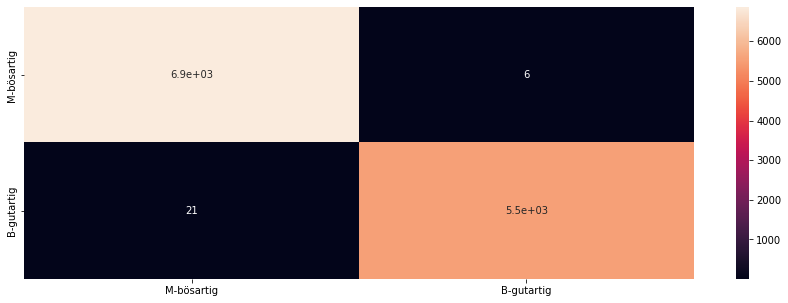

In [ ]:
##########################################
# Confusion Matrix of best Trial: best_trials[0]
# Accuracy= TP+TN/TP + FP + FN + TN  = TP + TN/ len(testdata)
# Precision = TP/TP+FP
# Recall = TP/TP+FN
##########################################
# Output Confusion matrix
 #[TN  FP]
 #[FN  TP]
###########################################
print('Testdata: ', len(x_test_d ) )
best_trial = study.best_trials[0]
print ('Best Trial number is: ', best_trial.number)
print('Confusion-Matrix:\n', cf_matrix["trial_"+str(best_trial.number)])
# print(best_trial)
df_cm = pd.DataFrame(cf_matrix["trial_"+str(best_trial.number)], index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,5))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
# FPR, TPR, Threshold
roc_df = pd.DataFrame(roc["trial_"+str(best_trial.number)])
roc_df

,fpr,tpr,threshold
0,0.000000,0.000000,2
1,0.000873,0.996216,1
2,1.000000,1.000000,0


In [ ]:
# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

AUC for our classifier is: {'trial_0': 0.9976711494967933, 'trial_1': 1.0, 'trial_2': 1.0, 'trial_3': 1.0, 'trial_4': 0.9644718404159931}


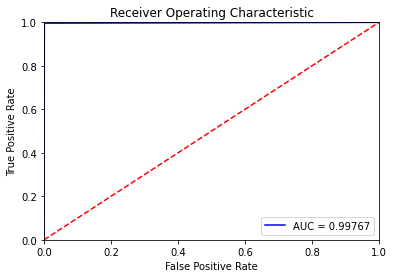

In [ ]:
# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc["trial_"+str(best_trial.number)])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## **Trial 0**

Testdata:  12420
Trial number is:  0
Confusion-Matrix:
 [[6865    6]
 [  21 5528]]


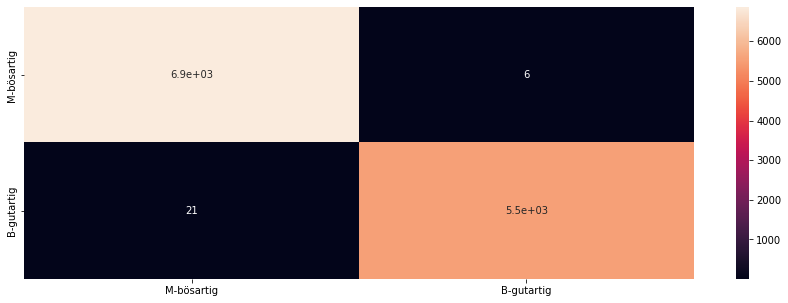

In [ ]:
# Trial 0
trial_number = 0
###############
print('Testdata: ', len(x_test_d) )
print ('Trial number is: ',str( trial_number))
###############
matrix = cf_matrix["trial_"+ str( trial_number)]
print('Confusion-Matrix:\n', matrix)
# plot cf_matrix
df_cm = pd.DataFrame(matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,5))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
# FPR, TPR, Threshold
roc_df = pd.DataFrame(roc["trial_"+ str( trial_number)])
roc_df

,fpr,tpr,threshold
0,0.000000,0.000000,2
1,0.000873,0.996216,1
2,1.000000,1.000000,0


In [ ]:
# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

AUC for our classifier is: {'trial_0': 0.9884296317857663, 'trial_1': 1.0, 'trial_2': 1.0, 'trial_3': 1.0, 'trial_4': 1.0, 'trial_5': 0.8916736535897397, 'trial_6': 0.9999272303885897, 'trial_7': 0.7855286251311695, 'trial_8': 0.9998544607771794, 'trial_9': 0.9857736917803438}


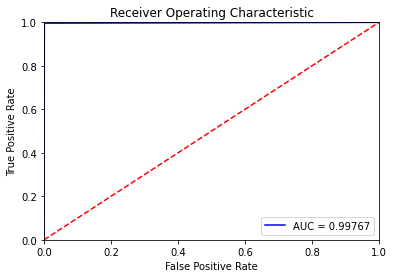

In [ ]:
# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc["trial_"+str(trial_number)])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## **Trial 1**

Testdata:  12420
Trial number is:  1
Confusion-Matrix:
 [[6871    0]
 [   0 5549]]


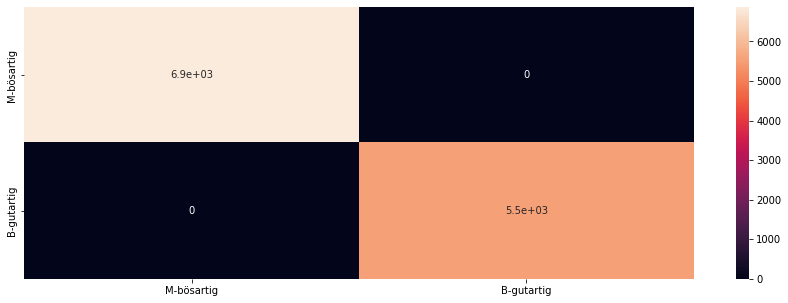

In [ ]:
# Trial 1
trial_number = 1
###############
print('Testdata: ', len(x_test_d) )
print ('Trial number is: ', str(trial_number))
###############
matrix = cf_matrix["trial_"+ str(trial_number)]
print('Confusion-Matrix:\n', matrix)
# plot cf_matrix
df_cm = pd.DataFrame(matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,5))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
# FPR, TPR, Threshold
roc_df = pd.DataFrame(roc["trial_"+ str( trial_number)])
roc_df

,fpr,tpr,threshold
0,0.0,0.0,2
1,0.0,1.0,1
2,1.0,1.0,0


In [ ]:
# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

AUC for our classifier is: {'trial_0': 0.9976711494967933, 'trial_1': 1.0, 'trial_2': 1.0, 'trial_3': 1.0, 'trial_4': 0.9644718404159931}


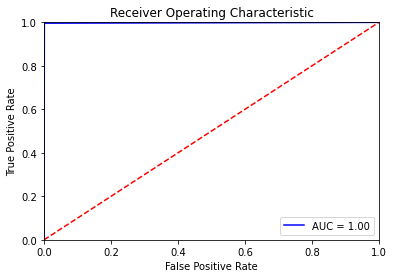

In [ ]:
# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc["trial_"+str(trial_number)])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## **Trial 2**

Testdata:  12420
Trial number is:  2
Confusion-Matrix:
 [[6871    0]
 [   0 5549]]


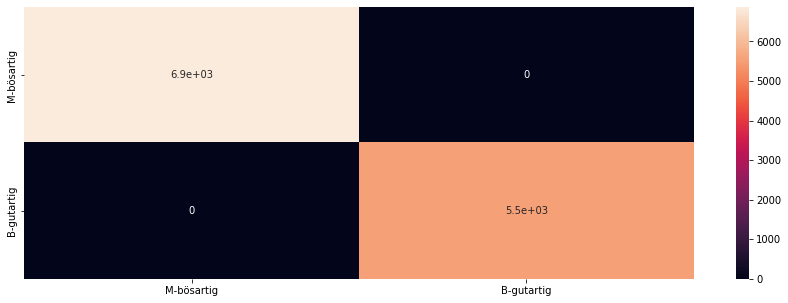

In [ ]:
# Trial 2
trial_number = 2
###############
print('Testdata: ', len(x_test_d) )
print ('Trial number is: ', str(trial_number))
###############
matrix = cf_matrix["trial_"+ str(trial_number)]
print('Confusion-Matrix:\n', matrix)
# plot cf_matrix
df_cm = pd.DataFrame(matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,5))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
# FPR, TPR, Threshold
roc_df = pd.DataFrame(roc["trial_"+ str(trial_number)])
roc_df

,fpr,tpr,threshold
0,0.0,0.0,2
1,0.0,1.0,1
2,1.0,1.0,0


In [ ]:
# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

AUC for our classifier is: {'trial_0': 0.9976711494967933, 'trial_1': 1.0, 'trial_2': 1.0, 'trial_3': 1.0, 'trial_4': 0.9644718404159931}


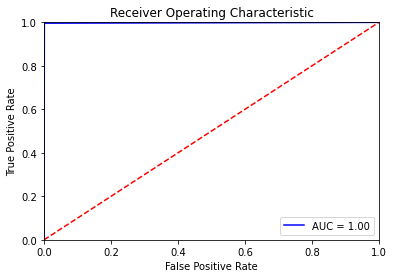

In [ ]:
# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc["trial_"+str(trial_number)])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## **Trial 3**

Testdata:  12420
Trial number is:  3
Confusion-Matrix:
 [[6871    0]
 [   0 5549]]


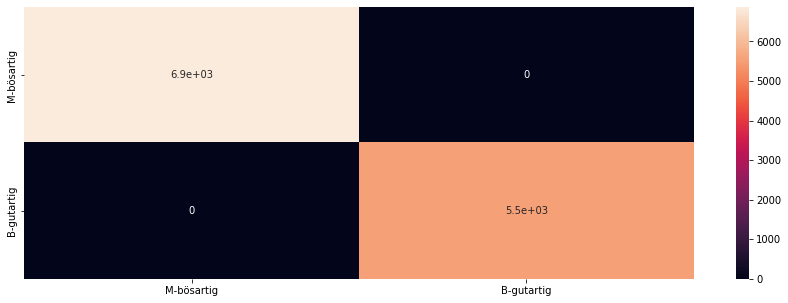

In [ ]:
# Trial 3
trial_number = 3
###############
print('Testdata: ', len(x_test_d) )
print ('Trial number is: ', str(trial_number))
###############
matrix = cf_matrix["trial_"+ str(trial_number)]
print('Confusion-Matrix:\n', matrix)
# plot cf_matrix
df_cm = pd.DataFrame(matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,5))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
# FPR, TPR, Threshold
roc_df = pd.DataFrame(roc["trial_"+ str(trial_number)])
roc_df

,fpr,tpr,threshold
0,0.0,0.0,2
1,0.0,1.0,1
2,1.0,1.0,0


In [ ]:
# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

AUC for our classifier is: {'trial_0': 0.9976711494967933, 'trial_1': 1.0, 'trial_2': 1.0, 'trial_3': 1.0, 'trial_4': 0.9644718404159931}


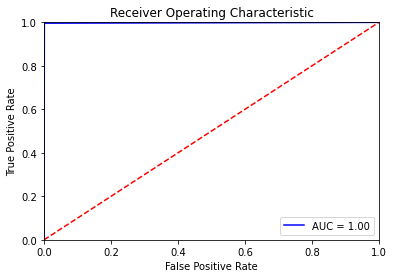

In [ ]:
# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc["trial_"+str(trial_number)])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## **Trial 4**

Testdata:  12420
Trial number is:  4
Confusion-Matrix:
 [[6701  170]
 [ 257 5292]]


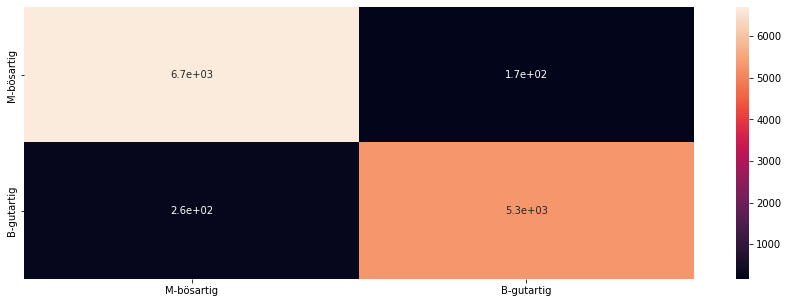

In [ ]:
# Trial 4
trial_number = 4
###############
print('Testdata: ', len(x_test_d) )
print ('Trial number is: ', str(trial_number))
###############
matrix = cf_matrix["trial_"+ str(trial_number)]
print('Confusion-Matrix:\n', matrix)
# plot cf_matrix
df_cm = pd.DataFrame(matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,5))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
# FPR, TPR, Threshold
roc_df = pd.DataFrame(roc["trial_"+ str(trial_number)])
roc_df

,fpr,tpr,threshold
0,0.000000,0.000000,2
1,0.024742,0.953685,1
2,1.000000,1.000000,0


In [ ]:
# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

AUC for our classifier is: {'trial_0': 0.9976711494967933, 'trial_1': 1.0, 'trial_2': 1.0, 'trial_3': 1.0, 'trial_4': 0.9644718404159931}


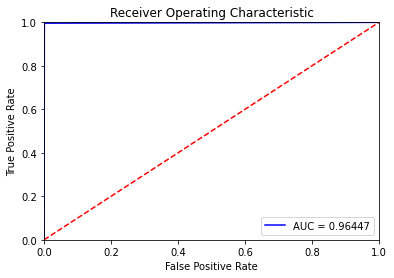

In [ ]:
# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc["trial_"+str(trial_number)])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## **F1-Score**

In [ ]:
#result as Dataframe
# F1-Score Max
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
df.rename({'values_0': 'Accuracy', 'values_1':'Precision', 'values_2': 'Recall', 'values_3': 'F1-Score' }, axis=1, inplace=True)
#df.index.names = ['id']
df.sort_values(by=['F1-Score'], ascending=False).head()

,Accuracy,Precision,Recall,F1-Score,params_batch_size,params_dropout_rate,params_dropout_rate2,params_fc2_input_dim,params_lr,params_optimizer,system_attrs_nsga2:generation
0,1.000000,1.000000,1.000000,1.000000,256,0.7,0.1,1024,0.005809,Adadelta,0
1,1.000000,1.000000,1.000000,1.000000,160,0.2,0.6,416,0.000140,Adagrad,0
2,1.000000,1.000000,1.000000,1.000000,96,0.0,0.7,1376,0.001505,Adagrad,0
3,1.000000,1.000000,1.000000,1.000000,96,0.2,0.3,1056,0.000040,Adagrad,0
4,0.984848,0.985507,0.985507,0.985507,192,0.3,0.0,960,0.000704,Adadelta,0


Test data:  12420
Best Trial number of F1-Score MAX is: 1
Confusion-Matrix:
 [[6871    0]
 [   0 5549]]


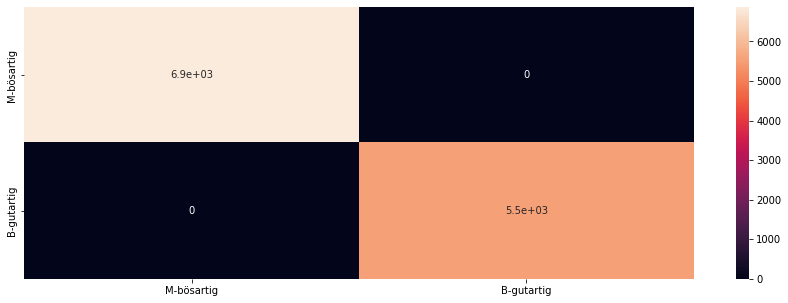

In [ ]:
# Confusion Matrix of best f1-Score
print('Test data: ', len(x_test_d ) )
print('Best Trial number of F1-Score MAX is:', 1)
print('Confusion-Matrix:\n', cf_matrix["trial_1"])
df_cm = pd.DataFrame(cf_matrix["trial_1"], index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,5))
sn.heatmap(df_cm, annot=True)
plt.show()

## **Recall**

In [ ]:
#result as Dataframe for Recall
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
df.rename({'values_0': 'Accuracy', 'values_1':'Precision', 'values_2': 'Recall', 'values_3': 'F1-Score' }, axis=1, inplace=True)
#df.index.names = ['id']
df.sort_values(by=['Recall'], ascending=False).head()

,Accuracy,Precision,Recall,F1-Score,params_batch_size,params_dropout_rate,params_dropout_rate2,params_fc2_input_dim,params_lr,params_optimizer,system_attrs_nsga2:generation
0,1.000000,1.000000,1.000000,1.000000,256,0.7,0.1,1024,0.005809,Adadelta,0
1,1.000000,1.000000,1.000000,1.000000,160,0.2,0.6,416,0.000140,Adagrad,0
2,1.000000,1.000000,1.000000,1.000000,96,0.0,0.7,1376,0.001505,Adagrad,0
3,1.000000,1.000000,1.000000,1.000000,96,0.2,0.3,1056,0.000040,Adagrad,0
4,0.984848,0.985507,0.985507,0.985507,192,0.3,0.0,960,0.000704,Adadelta,0


Test data:  12420
Best Trial number of MAX Recall: 0
Confusion-Matrix:
 [[6865    6]
 [  21 5528]]


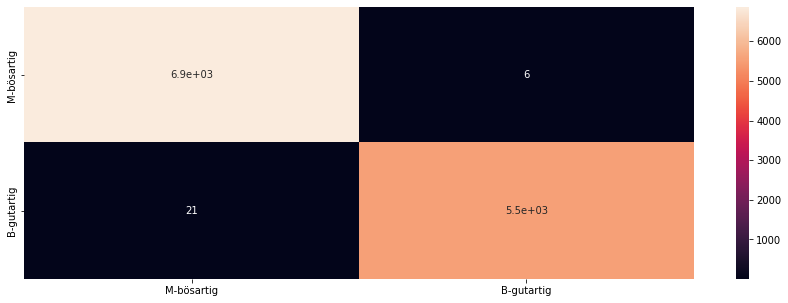

In [ ]:
# Confusion Matrix of best Recall
print('Test data: ', len(x_test_d ) )
print('Best Trial number of MAX Recall:', 1)
print('Confusion-Matrix:\n', cf_matrix["trial_1"])
df_cm = pd.DataFrame(cf_matrix["trial_1"], index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,5))
sn.heatmap(df_cm, annot=True)
plt.show()

# **ROC for Max Recall**

In [ ]:
# FPR, TPR, Threshold
roc_df = pd.DataFrame(roc["trial_1"])
roc_df

,fpr,tpr,threshold
0,0.0,0.0,2
1,0.0,1.0,1
2,1.0,1.0,0


In [ ]:
# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

AUC for our classifier is: {'trial_0': 0.9976711494967933, 'trial_1': 1.0, 'trial_2': 1.0, 'trial_3': 1.0, 'trial_4': 0.9644718404159931}


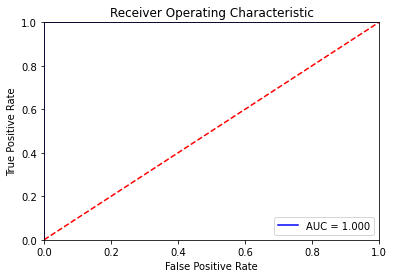

In [ ]:
# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc["trial_1"])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## **PLOT Classification metrics**

In [ ]:
# Plot metrics
colors = px.colors.qualitative.Plotly
fig = go.Figure()
fig.add_traces(go.Scatter(name='F1-Score',x=df.index, y = df['F1-Score'], mode = 'lines', line=dict(color=colors[0]))) 
fig.add_traces(go.Scatter(name='Recall', x=df.index, y = df['Recall'], mode = 'lines', line=dict(color=colors[2])))
fig.add_traces(go.Scatter(name='Precision',x=df.index, y = df['Precision'], mode = 'lines', line=dict(color=colors[1])))
fig.add_traces(go.Scatter(name='Accuracy',x=df.index, y = df['Accuracy'], mode = 'lines', line=dict(color=colors[3])))
fig.update_layout(title='Plot of metrics',legend_title_text='Metrics')
fig.update_xaxes(title_text='Trails')
fig.update_yaxes(title_text='Value')
fig.show()

## **Accuracy**

In [ ]:
#Plot train and test Accuracy
df_train_acc = pd.DataFrame(train_accuracy)
df_eval_acc = pd.DataFrame(eval_accuracy)
fig = go.Figure()
fig.add_trace(go.Scatter(y=df_train_acc.max(),name='train Accuracy'))
fig.add_trace(go.Scatter(y=df_eval_acc.max(), name='test Accuracy'))
fig.update_xaxes(title_text='Trails')
fig.update_yaxes(title_text='Accuracy')
fig.show()

### **Loss-Function**

In [ ]:
# Plot train and test loss
df_train_loss = pd.DataFrame(train_loss)
df_eval_loss = pd.DataFrame(eval_loss)
fig = go.Figure()
fig.add_trace(go.Scatter(y=df_train_loss.min(),name='train Loss'))
fig.add_trace(go.Scatter(y=df_eval_loss.min(), name='test Loss'))
fig.update_xaxes(title_text='Trails')
fig.update_yaxes(title_text='Loss')
fig.show()

## **Best Trials**

In [ ]:
# trails as Dataframe
df_trails = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
df_trails.rename({'values_0': 'Accuracy', 'values_1':'Precision', 'values_2': 'Recall', 'values_3': 'F1-Score' }, axis=1, inplace=True)
df_trails

,Accuracy,Precision,Recall,F1-Score,params_batch_size,params_dropout_rate,params_dropout_rate2,params_fc2_input_dim,params_lr,params_optimizer,system_attrs_nsga2:generation
0,1.000000,1.000000,1.000000,1.000000,256,0.7,0.1,1024,0.005809,Adadelta,0
1,1.000000,1.000000,1.000000,1.000000,160,0.2,0.6,416,0.000140,Adagrad,0
2,1.000000,1.000000,1.000000,1.000000,96,0.0,0.7,1376,0.001505,Adagrad,0
3,1.000000,1.000000,1.000000,1.000000,96,0.2,0.3,1056,0.000040,Adagrad,0
4,0.984848,0.985507,0.985507,0.985507,192,0.3,0.0,960,0.000704,Adadelta,0


## **Hyperparameter and F1-Score**

In [ ]:
#Plot Hyperparameters for F1-Score
optuna.visualization.plot_slice(study, target=lambda t: t.values[3], target_name="F1-Score")

## **Plot the 2 best Hyperparameter for F1-Score**

In [ ]:
#Plot Hyperparameters Importance for F1-Score
optuna.visualization.plot_param_importances(study, target=lambda t: t.values[3], target_name='F1-Score')

In [ ]:
# Plot fc2_layer and batch size
optuna.visualization.plot_contour(study, params=["fc2_input_dim", 'dropout_rate2'], target=lambda t: t.values[3], target_name='F1-Score')

## **Hyperparameter and Recall**


In [ ]:
#Plot Hyperparameters for Recall
optuna.visualization.plot_slice(study, target=lambda t: t.values[2], target_name="Recall")

In [ ]:
##Plot Hyperparameters Importance for Recall
optuna.visualization.plot_param_importances(study, target=lambda t: t.values[2], target_name='Recall')

## **Plot the 2 best Hyperparameter for Recall**

In [ ]:
# Plot fc2_layer and batch size
optuna.visualization.plot_contour(study, params=['dropout_rate2', "optimizer"], target=lambda t: t.values[2], target_name='Recall')

## **Hyperparameter and Precision**


In [ ]:
#Plot Hyperparameters for Precision
optuna.visualization.plot_slice(study, target=lambda t: t.values[1], target_name="Precision")

In [ ]:
#Plot Hyperparameters Importance for Recall
optuna.visualization.plot_param_importances(study, target=lambda t: t.values[1], target_name='Precision')

## **Plot the 2 best Hyperparameter for Precision**

In [ ]:
# Plot fc2_layer and batch size
optuna.visualization.plot_contour(study, params=["fc2_input_dim", 'dropout_rate2'], target=lambda t: t.values[1], target_name='Precision')

# **Hyperparameter and Accuracy**

In [ ]:
#Plot Hyperparameters Importance for Recall
optuna.visualization.plot_param_importances(study, target=lambda t: t.values[0], target_name='Accuracy')

In [ ]:
# Plot fc2_layer and batch size
optuna.visualization.plot_contour(study, params=["fc2_input_dim", 'dropout_rate2'], target=lambda t: t.values[0], target_name='Accuracy')

## **Plot Networks with Hyperparameter**

In [ ]:
optuna.visualization.plot_parallel_coordinate(study, target=lambda t: t.values[3], target_name='F1-Score')

In [ ]:
optuna.visualization.plot_parallel_coordinate(study, target=lambda t: t.values[0], target_name='Accuracy')

In [ ]:
#the 3 best trials
print("number of best trials : {}".format(len(study.best_trials)))
print('Accuracy, Precision, Recall, F1-Score')
for i in range(len(study.best_trials)):
  print(study.best_trials[i])

number of best trials : 4
Accuracy, Precision, Recall, F1-Score
FrozenTrial(number=0, values=[1.0, 1.0, 1.0, 1.0], datetime_start=datetime.datetime(2022, 5, 17, 19, 26, 2, 878541), datetime_complete=datetime.datetime(2022, 5, 17, 19, 35, 1, 734150), params={'dropout_rate': 0.7000000000000001, 'fc2_input_dim': 1024, 'dropout_rate2': 0.1, 'optimizer': 'Adadelta', 'lr': 0.00580851912609547, 'batch_size': 256}, distributions={'dropout_rate': DiscreteUniformDistribution(high=0.9, low=0.0, q=0.1), 'fc2_input_dim': IntUniformDistribution(high=2048, low=32, step=32), 'dropout_rate2': DiscreteUniformDistribution(high=0.9, low=0.0, q=0.1), 'optimizer': CategoricalDistribution(choices=('Adam', 'Adadelta', 'Adagrad')), 'lr': LogUniformDistribution(high=0.1, low=1e-05), 'batch_size': IntUniformDistribution(high=256, low=32, step=32)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)
FrozenTrial(number=1, values=[1.0, 1.0

In [ ]:
# Printing AUC
print(f"AUC for our classifier is:\n{roc_auc}")

AUC for our classifier is:
{'trial_0': 0.9976711494967933, 'trial_1': 1.0, 'trial_2': 1.0, 'trial_3': 1.0, 'trial_4': 0.9644718404159931}


## **Model with best Hyperparameters**

In [ ]:
# Best hyperparameters:
# Trial 0: 
# params={'dropout_rate': 0.7000000000000001, 'fc2_input_dim': 1024, 'dropout_rate2': 0.1, 'optimizer': 'Adadelta', 'lr': 0.00580851912609547, 'batch_size': 256}
dropout_rate = 0.7000000000000001
fc2_input_dim = 1024
dropout_rate2 =  0.1
lr = 0.00580851912609547
batch_size = 256

In [ ]:
# Best hyperparameters: 
#Trial 1
# params={'dropout_rate': 0.2, 'fc2_input_dim': 416, 'dropout_rate2': 0.6000000000000001, 'optimizer': 'Adagrad', 'lr': 0.0001395247129494778, 'batch_size': 160}
# dropout_rate = 0.2
# fc2_input_dim = 416
# dropout_rate2 =  0.6000000000000001
# lr = 0.0001395247129494778
# batch_size = 160

In [ ]:
# Model made with best hyperparameters

class best_model(nn.Module):
  def __init__(self):
    # We optimize dropout rate in a convolutional neural network.
    super(best_model, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv1_bn = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv2_bn = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv3_bn = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv4_bn = nn.BatchNorm2d(128)
    self.drop1=nn.Dropout(p=dropout_rate)   
    self.fc1 = nn.Linear(128*32*32, fc2_input_dim)
    self.fc1_bn = nn.BatchNorm1d(fc2_input_dim)
    self.drop2=nn.Dropout(p=dropout_rate2)
    self.fc2 = nn.Linear(fc2_input_dim, 2)
  
  def forward(self, x):  # Conv - BatchNorm - Activ - Pool - Drop
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        x = self.conv4(x)        
        x = F.relu(F.max_pool2d(self.conv4_bn(x),kernel_size = 2,stride=2))
        x = self.drop1(x)
        x = x.view(x.size(0),-1)  # Flatten
        x = self.fc1(x)
        x = F.relu(self.fc1_bn(x))
        x = self.drop2(x)
        x = self.fc2(x)
        return x
model = best_model()
model.type(torch.cuda.FloatTensor).to(device)
from torchsummary import summary
summary(model, (1, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
            Conv2d-3           [-1, 64, 64, 64]          18,496
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5          [-1, 128, 64, 64]          73,856
       BatchNorm2d-6          [-1, 128, 64, 64]             256
            Conv2d-7          [-1, 128, 64, 64]         147,584
       BatchNorm2d-8          [-1, 128, 64, 64]             256
           Dropout-9          [-1, 128, 32, 32]               0
           Linear-10                 [-1, 1024]     134,218,752
      BatchNorm1d-11                 [-1, 1024]           2,048
          Dropout-12                 [-1, 1024]               0
           Linear-13                    [-1, 2]           2,050
Total params: 134,463,810
Trainable par

In [ ]:
#Optimizier
###########################################################
## Adam
#optimizer = optim.Adam(model.parameters(), lr)  
## Adadelta: 
optimizer = optim.Adadelta(model.parameters(), lr) 
## Adagrad:
#optimizer = optim.Adagrad(model.parameters(), lr) 
###########################################################
train_loader = DataLoader(x_train_d, batch_size, shuffle=True)
valid_loader = DataLoader(x_test_d, batch_size,shuffle=True)

In [ ]:
# Model training 
# Loss calculation function
# Accuracy
Epochs=100
criterion=nn.CrossEntropyLoss()
for epoch in tqdm.trange(Epochs):
        model.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.type(torch.cuda.FloatTensor).to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels).to(device)
            pred = output.argmax(dim=1, keepdim=True)
            acc_train = accuracy_score(labels.view(-1).cpu(), pred.cpu())
            loss.backward()
            optimizer.step()

100%|██████████| 100/100 [1:19:22<00:00, 47.62s/it]


In [ ]:
print("model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

model: 

 best_model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.7000000000000001, inplace=False)
  (fc1): Linear(in_features=131072, out_features=1024, bias=True)
  (fc1_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=1024,

In [ ]:
#save model
url = '/content/drive/MyDrive/Breast_cancer_pytorch/models/'
torch.save({
            'epoch': Epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, url+ 'BCClassifier_Trial_0.pth')

# **TESTING**

In [ ]:

## Read all images labels and return each image name with Its label
from google.colab import drive
drive.mount('/content/drive/', force_remount=False)
labels_dataset_url =  '/content/drive/MyDrive/Breast_cancer_pytorch/dataset/'
filename = labels_dataset_url + 'image_infos.txt'
text_all = open(filename).read()
lines = text_all.split('\n')
del lines[0]
labels = {}
for line in lines:
  words = line.split(' ')
  if len(words)>3:
    if (words[3] == 'B'):
      labels[words[0]] = {}
      labels[words[0]] = 'Benign'
    if (words[3] == 'M'):
      labels[words[0]] = {}
      labels[words[0]] = "Malignant"
print(labels)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
{'mdb001': 'Benign', 'mdb002': 'Benign', 'mdb005': 'Benign', 'mdb010': 'Benign', 'mdb012': 'Benign', 'mdb013': 'Benign', 'mdb015': 'Benign', 'mdb017': 'Benign', 'mdb019': 'Benign', 'mdb021': 'Benign', 'mdb023': 'Malignant', 'mdb025': 'Benign', 'mdb028': 'Malignant', 'mdb030': 'Benign', 'mdb032': 'Benign', 'mdb058': 'Malignant', 'mdb059': 'Benign', 'mdb063': 'Benign', 'mdb069': 'Benign', 'mdb072': 'Malignant', 'mdb075': 'Malignant', 'mdb080': 'Benign', 'mdb081': 'Benign', 'mdb083': 'Benign', 'mdb090': 'Malignant', 'mdb091': 'Benign', 'mdb092': 'Malignant', 'mdb095': 'Malignant', 'mdb097': 'Benign', 'mdb099': 'Benign', 'mdb102': 'Malignant', 'mdb104': 'Benign', 'mdb105': 'Malignant', 'mdb107': 'Benign', 'mdb110': 'Malignant', 'mdb111': 'Malignant', 'mdb115': 'Malignant', 'mdb117': 'Malignant', 'mdb120': 'Malignant', 'mdb121': 'Benign', 'mdb124': 'Malignant', 

In [ ]:
## Read all images and return them in a dictionary
image_dataset_url = '/content/drive/MyDrive/Breast_cancer_pytorch/dataset/'
images = {}
tfms = transforms.Compose([
          transforms.Resize((64, 64)),
          transforms.ToTensor()])
images_in_labels = list(labels.keys())
for i in tqdm.trange(322):
  if i<9:
    image_name='mdb00'+str(i+1)
  elif i<99:
    image_name='mdb0'+str(i+1)
  else:
    image_name = 'mdb' + str(i+1)
  if image_name in images_in_labels :
    image_address = image_dataset_url + image_name + '.pgm'
    # use cv2
    img = cv2.imread(image_address, 0)
    # img = Image.open(image_address)
    img = cv2.resize(img, (64,64))
    # img = tfms(img).to(device).unsqueeze(0)
    img = torch.from_numpy(img)
    img = img.to(device).unsqueeze(0)
    img = img.to(device).unsqueeze(0)
    images[image_name]={}
    images[image_name]= img

100%|██████████| 322/322 [00:38<00:00,  8.44it/s]


In [ ]:
## Counting true positive
import math
def ploting_roc_auc(fpr, tpr, roc_auc):
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1.003], [0, 1.003],'r--')
  plt.xlim([-0.003, 1])
  plt.ylim([0, 1.003])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

def evaluate_modal(model, model_name):
  tp_counter = 0
  prediction = {}
  precision = []
  recall = []
  true_labels = []
  predicted_labels = []
  images_with_right_prediction = []
  images_with_wrong_prediction = []
  roc_curve_list = []

  for key in images.keys():
    image = images[key].type(torch.cuda.FloatTensor).to(device)
    output = model(image)
    output = output.cpu().data.numpy().argmax()
    prediction[key] = {}
    prediction[key]['predicted'] = "Benign" if output == 0 else "Malignant"
    prediction[key]['true'] = labels[key]
    tp_counter = ( tp_counter +1 ) if prediction[key]['predicted'] == labels[key] else ( tp_counter +0 )
    if prediction[key]['predicted'] == labels[key]:
      images_with_right_prediction.append(key)
    else :
      images_with_wrong_prediction.append(key)
    true_labels.append(0 if labels[key] == 'Benign' else 1)
    predicted_labels.append(output)

  prediction_df = pd.DataFrame(prediction)
  prediction_df = prediction_df.transpose()
  # display(prediction_df)
  tp_rate = tp_counter/len(images_in_labels)*100
  print(500*"*")
  # print('Efficiency of modal '+model_name + ' is : ' + str(round(tp_rate, 2))+'%')
  print('Accuracy for model {} is {} \n'.format(model_name, accuracy_score(true_labels, predicted_labels)))
  print('Recall for model {} is {} \n'.format(model_name, recall_score(true_labels, predicted_labels)))
  print('Precision for model {} is {} \n'.format(model_name, precision_score(true_labels, predicted_labels)))
  
  print(images_with_right_prediction)
  print("\nNumber of images with right prediction : {} \n".format(len(images_with_right_prediction)))
  print("Images with wrong prediction : ")
  print(images_with_wrong_prediction)
  print("\nNumber of images with wrong prediction :{} \n".format(len(images_with_wrong_prediction)))
  print(500*"*")

  ## Labels with true prediction
  ### ROC and AUC and Its ploting
  print(f"\nAUC Shape\n")
  fpr, tpr, threshold = roc_curve(true_labels, predicted_labels)
  auc_value = auc(fpr, tpr)
  ploting_roc_auc(fpr, tpr, auc_value)

  ## Confusion matrix
  print(f"\nConfusion Matrix\n")
  classes = classes = ('M-bösartig', 'B-gutartig')
  conf_mat = confusion_matrix(true_labels, predicted_labels)
  df_cm = pd.DataFrame(conf_mat, index = [i for i in classes], columns = [i for i in classes])
  plt.figure(figsize = (15,5))
  sn.heatmap(df_cm, annot=True)
  plt.show()

# **Test the best model**

********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************
Accuracy for model BCClassifier_Trial_0.pth is 1.0 

Recall for model BCClassifier_Trial_0.pth is 1.0 

Precision for model BCClassifier_Trial_0.pth is 1.0 

['mdb001', 'mdb002', 'mdb005', 'mdb010', 'mdb012', 'mdb013', 'mdb015', 'mdb017', 'mdb019', 'mdb021', 'mdb023', 'mdb025', 'mdb028', 'mdb030', 'mdb032', 'mdb058', 'mdb059', 'mdb063', 'mdb069', 'mdb072', 'mdb075', 'mdb080', 'mdb081', 'mdb083', 'mdb090', 'mdb091', 'mdb092', 'mdb095', 'mdb097', 'mdb099', 'mdb102', 'mdb104', 'mdb105', 'mdb107', 

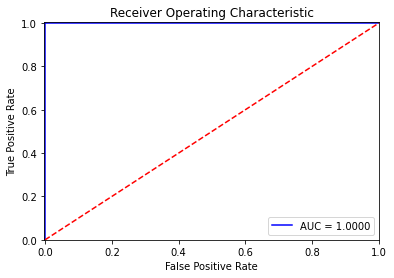


Confusion Matrix



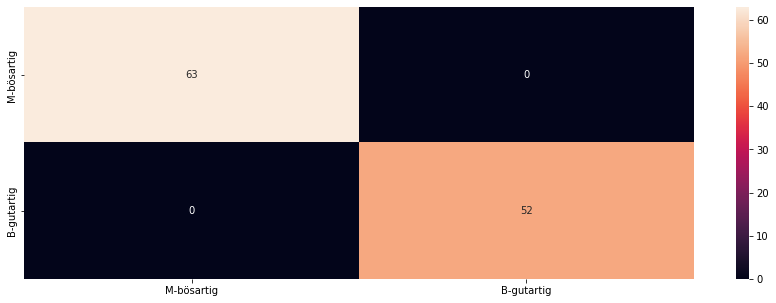

********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************
Accuracy for model BCClassifier_Trial_1.pth is 1.0 

Recall for model BCClassifier_Trial_1.pth is 1.0 

Precision for model BCClassifier_Trial_1.pth is 1.0 

['mdb001', 'mdb002', 'mdb005', 'mdb010', 'mdb012', 'mdb013', 'mdb015', 'mdb017', 'mdb019', 'mdb021', 'mdb023', 'mdb025', 'mdb028', 'mdb030', 'mdb032', 'mdb058', 'mdb059', 'mdb063', 'mdb069', 'mdb072', 'mdb075', 'mdb080', 'mdb081', 'mdb083', 'mdb090', 'mdb091', 'mdb092', 'mdb095', 'mdb097', 'mdb099', 'mdb102', 'mdb104', 'mdb105', 'mdb107', 

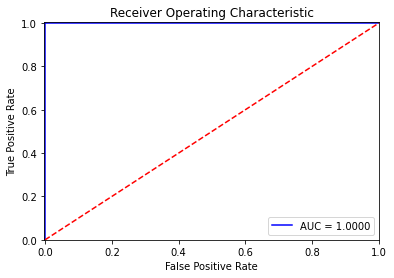


Confusion Matrix



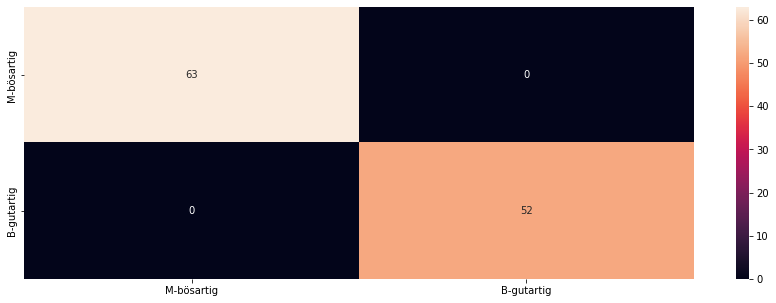

In [ ]:
class best_model(nn.Module):
  def __init__(self, dropout_rate, fc2_input_dim, dropout_rate2):
    # We optimize dropout rate in a convolutional neural network.
    super(best_model, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv1_bn = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv2_bn = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv3_bn = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv4_bn = nn.BatchNorm2d(128)
    self.drop1=nn.Dropout(p=dropout_rate)   
    self.fc1 = nn.Linear(128*32*32, fc2_input_dim)
    self.fc1_bn = nn.BatchNorm1d(fc2_input_dim)
    self.drop2=nn.Dropout(p=dropout_rate2)
    self.fc2 = nn.Linear(fc2_input_dim, 2)
  
  def forward(self, x):  # Conv - BatchNorm - Activ - Pool - Drop
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        x = self.conv4(x)        
        x = F.relu(F.max_pool2d(self.conv4_bn(x),kernel_size = 2,stride=2))
        x = self.drop1(x)
        x = x.view(x.size(0),-1)  # Flatten
        x = self.fc1(x)
        x = F.relu(self.fc1_bn(x))
        x = self.drop2(x)
        x = self.fc2(x)
        return x
model_save_names= {'BCClassifier_Trial_0.pth':
                   {
                    "dropout_rate": 0.7000000000000001,
                    "fc2_input_dim":1024,
                    "dropout_rate2":  0.1,
                    "lr": 0.00580851912609547,
                    "batch_size":256,
                    "optimizer": "Adadelta"
                   },
                   'BCClassifier_Trial_1.pth': {
                       "dropout_rate": 0.2,
                       "fc2_input_dim": 416, 
                       "dropout_rate2": 0.6000000000000001,
                       "lr": 0.0001395247129494778,
                       "batch_size": 160,
                       "optimizer": "Adagrad"
                   }
                   }

url_models = '/content/drive/MyDrive/Breast_cancer_pytorch/models/'

for model_name in model_save_names:
  dropout_rate = model_save_names[model_name]["dropout_rate"]
  fc2_input_dim = model_save_names[model_name]["fc2_input_dim"]
  dropout_rate2 = model_save_names[model_name]["dropout_rate2"]
  lr = model_save_names[model_name]["lr"]
  batch_size = model_save_names[model_name]["batch_size"]
  optimizer = model_save_names[model_name]["optimizer"]

  PATH = url_models + model_name

  # train_loader = DataLoader(x_train_d, batch_size, shuffle=True)
  # valid_loader = DataLoader(x_test_d, batch_size, shuffle=True)

  # # Create a basic model instance
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  model = best_model(dropout_rate, fc2_input_dim, dropout_rate2)
  model.type(torch.cuda.FloatTensor).to(device)
  model.eval()

  ## Load optmizer
  if optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr)
  elif optimizer == 'Adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr)
  else :
    optimizer = optim.Adadelta(model.parameters(), lr)

  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']

  # model.eval() # or model.train()
  evaluate_modal(model, model_name)
  #torch.cuda.empty_cache()